In [1]:
# --------------------------------------------
# 1. Setup and Imports
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# -------------------------------------------------
# 2. Load Data and Parse 'date'
# -------------------------------------------------
df = pd.read_csv("train.csv")

# Convert 'date' from YYYYMMDDHH to datetime
df['datetime'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d%H')

# Set datetime as index (optional, but useful for time series)
df.set_index('datetime', inplace=True)

# Drop the old 'date' column if not needed
df.drop(columns=['date'], inplace=True)

df.head()

# --------------------------------------------
# 2. Basic Info and Structure
# --------------------------------------------
print("Data Shape:", df.shape)
df.info()
df.describe()



Data Shape: (18757, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18757 entries, 2009-07-01 00:00:00 to 2012-06-26 12:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wp1     18757 non-null  float64
 1   wp2     18757 non-null  float64
 2   wp3     18757 non-null  float64
 3   wp4     18757 non-null  float64
 4   wp5     18757 non-null  float64
 5   wp6     18757 non-null  float64
 6   wp7     18757 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


,wp1,wp2,wp3,wp4,wp5,wp6,wp7
count,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000
mean,0.252388,0.265983,0.334571,0.286173,0.272584,0.286774,0.290542
std,0.246381,0.273205,0.318636,0.295069,0.294221,0.283023,0.305272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.042000,0.069000,0.022000,0.040000,0.053000,0.025000
50%,0.175000,0.164000,0.217000,0.182000,0.157000,0.184000,0.177000
75%,0.381000,0.423000,0.563000,0.474000,0.415000,0.461000,0.505000
max,0.947000,0.989000,0.978000,0.992000,0.966000,0.974000,0.960000


In [2]:
# -------------------------------------------------
# 4. Check for Missing Values and Duplicates
# -------------------------------------------------
print("Missing values:\n", df.isnull().sum())
print("Duplicated rows:", df.duplicated().sum())


Missing values:
 wp1    0
wp2    0
wp3    0
wp4    0
wp5    0
wp6    0
wp7    0
dtype: int64
Duplicated rows: 94


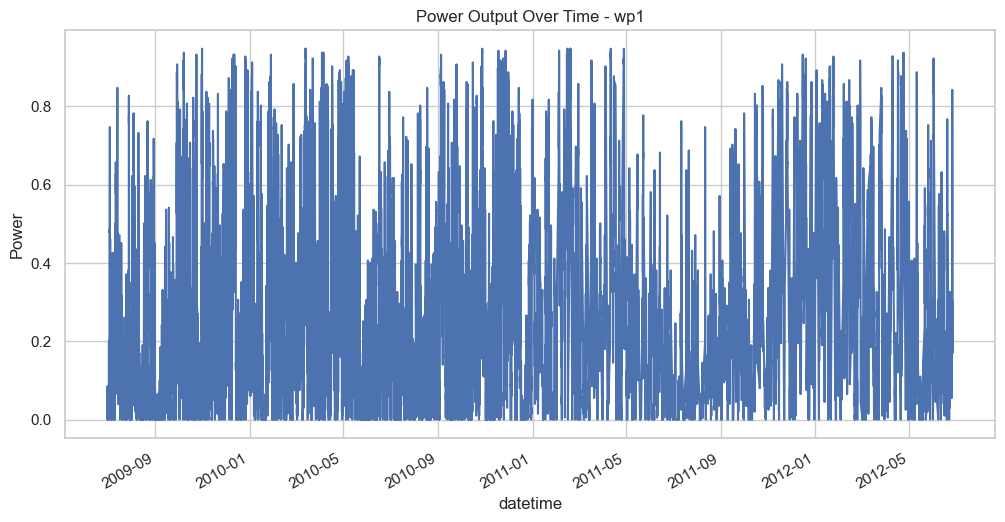

In [3]:
# -------------------------------------------------
# 5. Power Output Over Time (Example: wp1)
# -------------------------------------------------
df['wp1'].plot(title='Power Output Over Time - wp1', ylabel='Power')
plt.show()


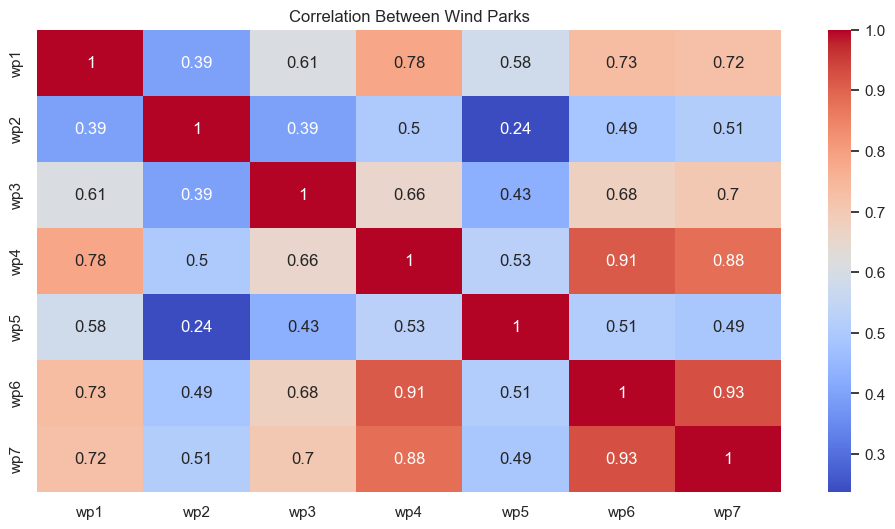

In [4]:
# -------------------------------------------------
# 6. Correlation Check Between Wind Parks
# -------------------------------------------------
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Wind Parks")
plt.show()


In [5]:
#Preprocessing 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


# Taking just one coloumn to create a simplified baseline model
data = df[['wp1']].copy()


# Create shifted target column for next-hour prediction
data['target'] = data['wp1'].shift(-1)
data.dropna(inplace=True)  # Drop the last row with no label

# data['target'].values


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(data[['wp1']])
y = data['target'].values


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Important: no shuffling in time series!
)


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # Output: regression
])

model.compile(optimizer='adam', loss='mse' ,  metrics=['mae'])
model.summary()


C:\Users\Jamal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)


Epoch 1/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0552 - mae: 0.1466 - val_loss: 0.0069 - val_mae: 0.0553
Epoch 2/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056 - mae: 0.0514 - val_loss: 0.0070 - val_mae: 0.0541
Epoch 3/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mae: 0.0511 - val_loss: 0.0068 - val_mae: 0.0527
Epoch 4/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - mae: 0.0504 - val_loss: 0.0067 - val_mae: 0.0523
Epoch 5/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - mae: 0.0499 - val_loss: 0.0067 - val_mae: 0.0519
Epoch 6/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0052 - mae: 0.0491 - val_loss: 0.0067 - val_mae: 0.0518
Epoch 7/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0050 - mae: 0.0479 - val_loss: 0.0067 - val_mae: 0.0519
Epoch 8/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - mae: 0.0488 - val_loss: 0.0067 - val_mae: 0.0530
Epoch 9/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

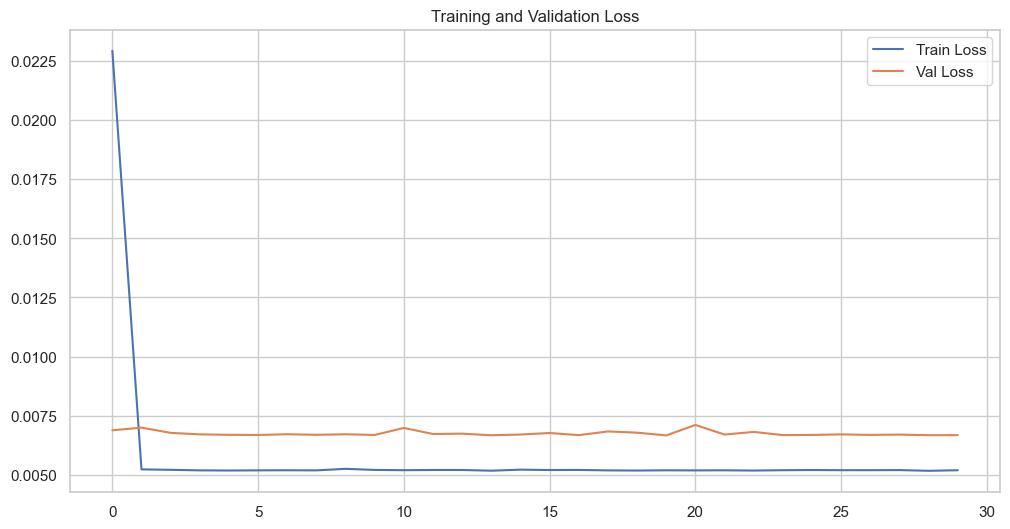

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

y_pred_nn = model.predict(X_test)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print(f"Neural Network Test MAE: {mae_nn:.4f} || RMSE: {rmse_nn:.5f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Neural Network Test MAE: 0.0568 || RMSE: 0.09320


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


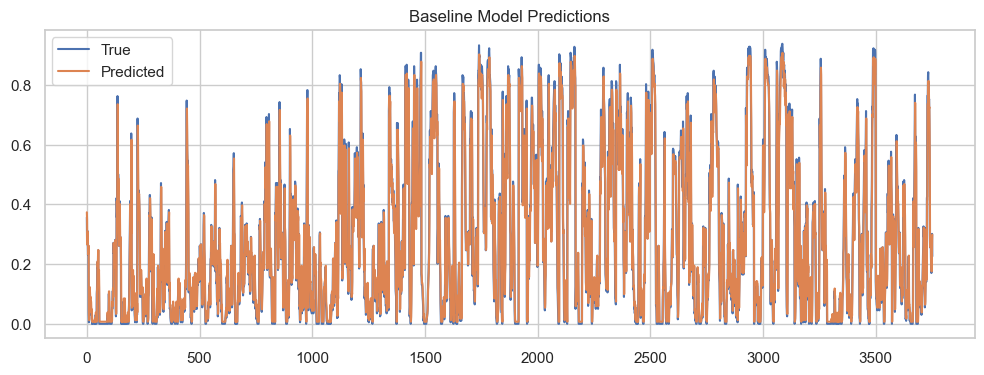

In [12]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Baseline Model Predictions')
plt.legend()
plt.show()


In [13]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression Test MAE: {mae_lr:.5f} || RMSE: {rmse_lr:.5f} ")


Linear Regression Test MAE: 0.05709 || RMSE: 0.09319 


### Model Performance Comparison

| Model                          |  MAE | RMSE |  
|--------------------------------|----------|------| 
| Sequential NN (1-feature, 1-step, MLP) |  0.0571 | 0.09323 |
| Linear Regression              | 0.05709 | 0.09319 |
